In [105]:
! pip install matplotlib numpy

# Ray Tracing

## Grundlagen

Was ist die grundlegende Idee von Raytracing?
Wichtig ist dafür zuerst zu verstehen wie Licht funktioniert.

Ein einfacher Ansatz dafür ist, anzunehmen das Licht aus Strahlen besteht.  
Diese Strahlen werden aus einer Lichtquelle ausgesendet, werden von Objekten reflektiert und absorbiert und zu guter Letzt kommen sie bei dem Beobachter an.  
Der Beobachter wird hier Kamera genannt.

Schematisch und zweidimensional sieht das so aus:
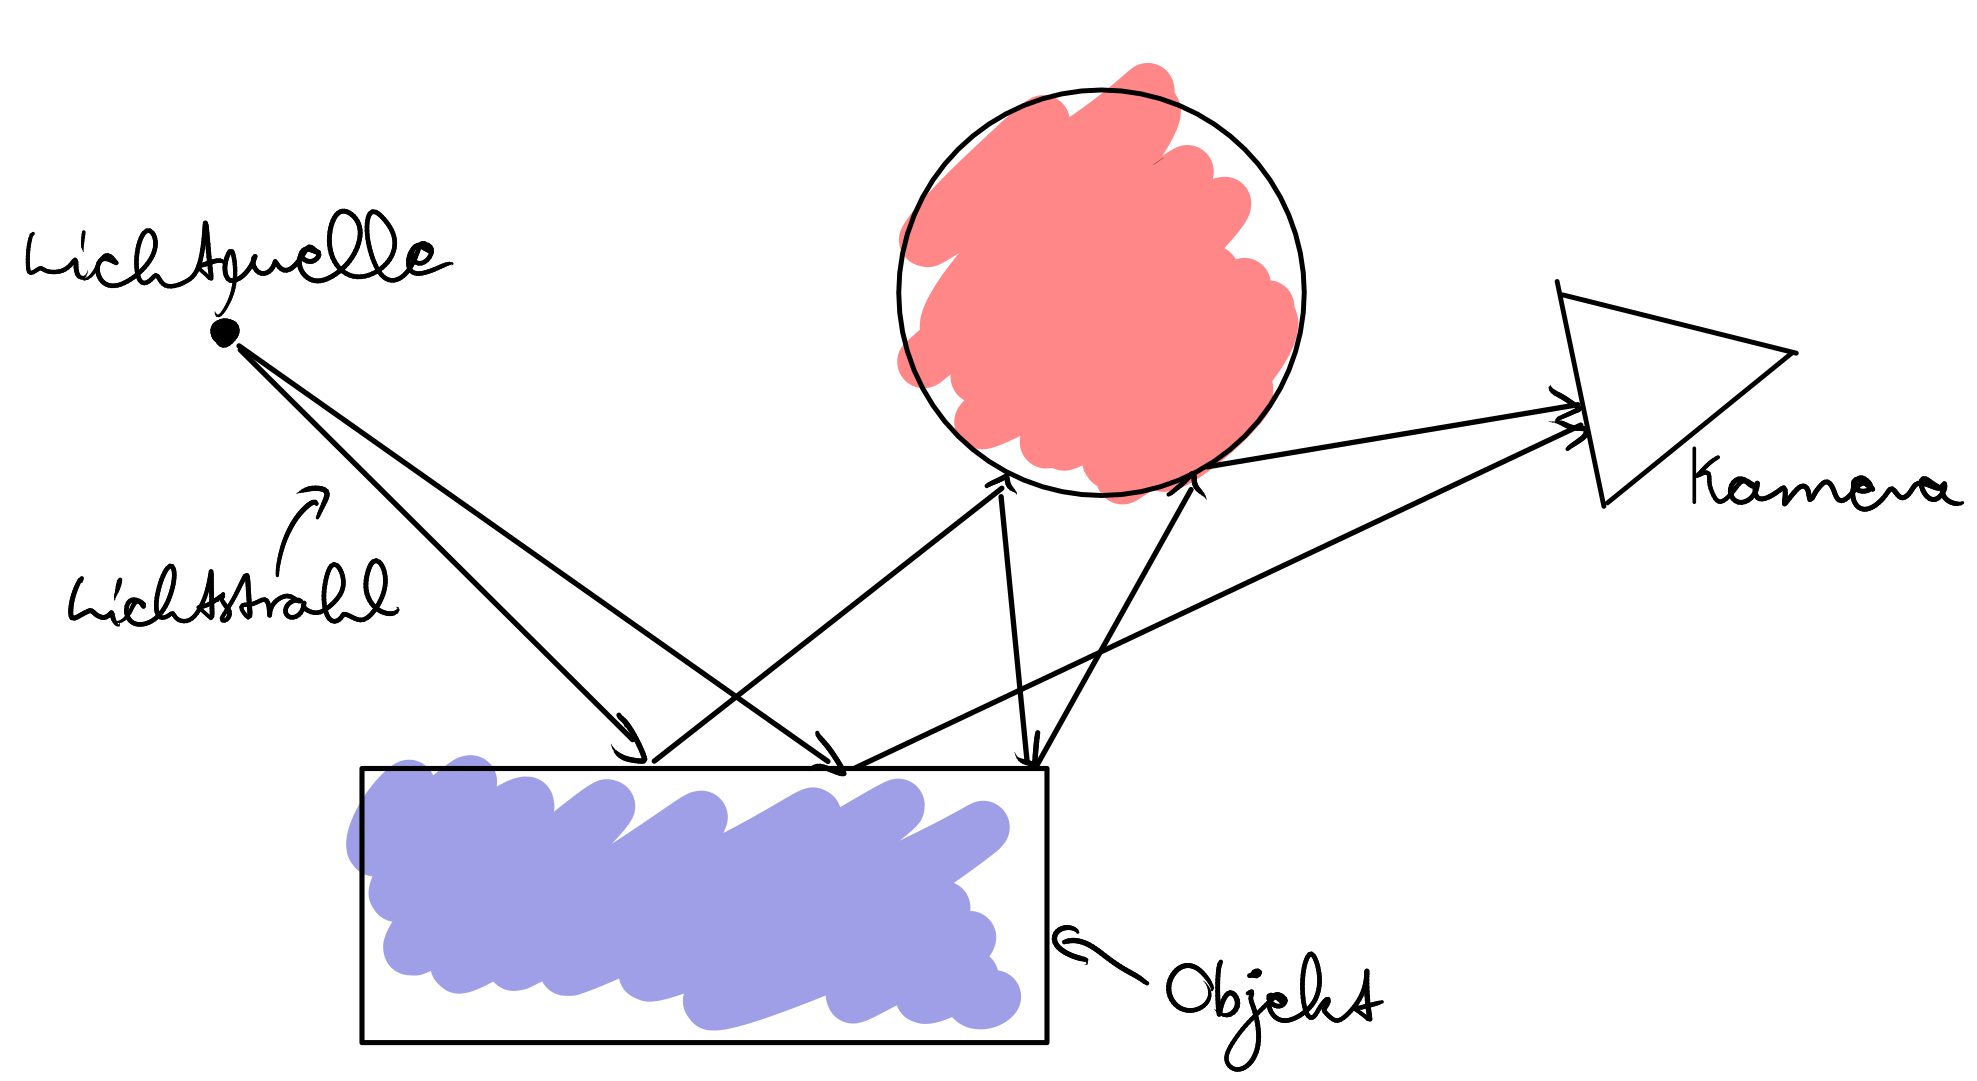

Schritt für Schritt müssen also folgende Dinge geschehen:

1. Die Lichtquelle sendet einen Lichtstrahl aus
2. Dieser Lichtstrahl trifft auf ein Objekt
3. Das Objekt reflektiert und absorbiert einen Teil des Lichts
4. Schritt 2 und 3 wiederholen sich bis der Lichtstrahl entweder eine Kamera oder kein Objekt mehr trifft
5. Lichtstrahl trifft auf die Kamera
6. Schritt 1 bis 6 werden wiederholt bis der Nutzer mit dem gerenderten Bild zufrieden ist

Dieser Ansatz ist allerdings sehr ineffizient, da dann viele Lichtstrahlen keine Kamera treffen.
Für eine bessere Optimierung werden die Lichtstrahlen aus der Kamera ausgesendet und der Lichtpfad wird erst nach dem Auftreffen auf die Lichtquelle vollständig berechnet.


## Lichtstrahlen (Rays)
    
Ein Lichtstrahl besteht aus Ortsvektor und Richtungsvektor.
Der Ortsvektor gibt dabei den Punkt an, an dem der Lichtstrahl ausgesendet wurde
und der Richtungsvektor die Richtung in die der Strahl gesendet wird.  
Also $\vec{ray(t)}=\vec{O}+\vec{d}*t$
außerdem hat ein Lichtstrahl eine Farbe `color`, die ist zu Beginn `[1,1,1]`

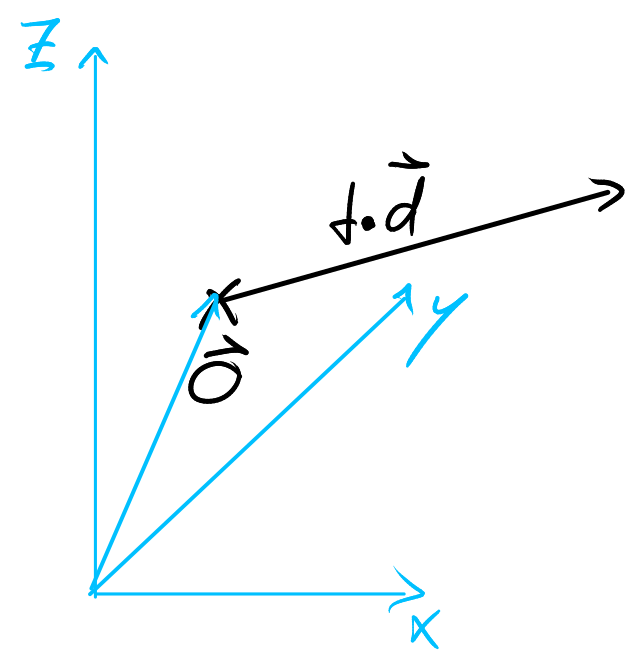

in Python definieren wir einen Ray so:

In [106]:
import numpy as np
import numpy.typing as npt
from typing import NamedTuple, Tuple

Vec = npt.NDArray[np.float64]
Color = npt.NDArray[np.float64]

class Ray(NamedTuple):
    location: Vec
    direction: Vec
    color: Color
    
    def at(self, t):
        return self.location + t * self.direction


Typischerweise ist der Richtungsvektor normiert, dafür dient diese Funktion

In [107]:
def normalizeVector(vec: Vec):
    return vec/np.linalg.norm(vec)

print(normalizeVector(np.array([1, 2, 3])))


[0.26726124 0.53452248 0.80178373]


## Aussenden eines Lichtstrahls

Die Kamera sendet Lichtstrahlen aus.
Die Kamera ist modelliert als eine Lochkamera. Es gibt einen Sensor, auf dem alle Pixel liegen. 
Der Sensor ist eine Fläche.
Alle Lichtstrahlen gehen von einem Punkt aus, der *Lochblende*.
Jeder Lichtstrahl geht in Richtung eines Pixels, sodass am Ende jedes Pixel einem Lichtstrahl zugeordnet werden kann.

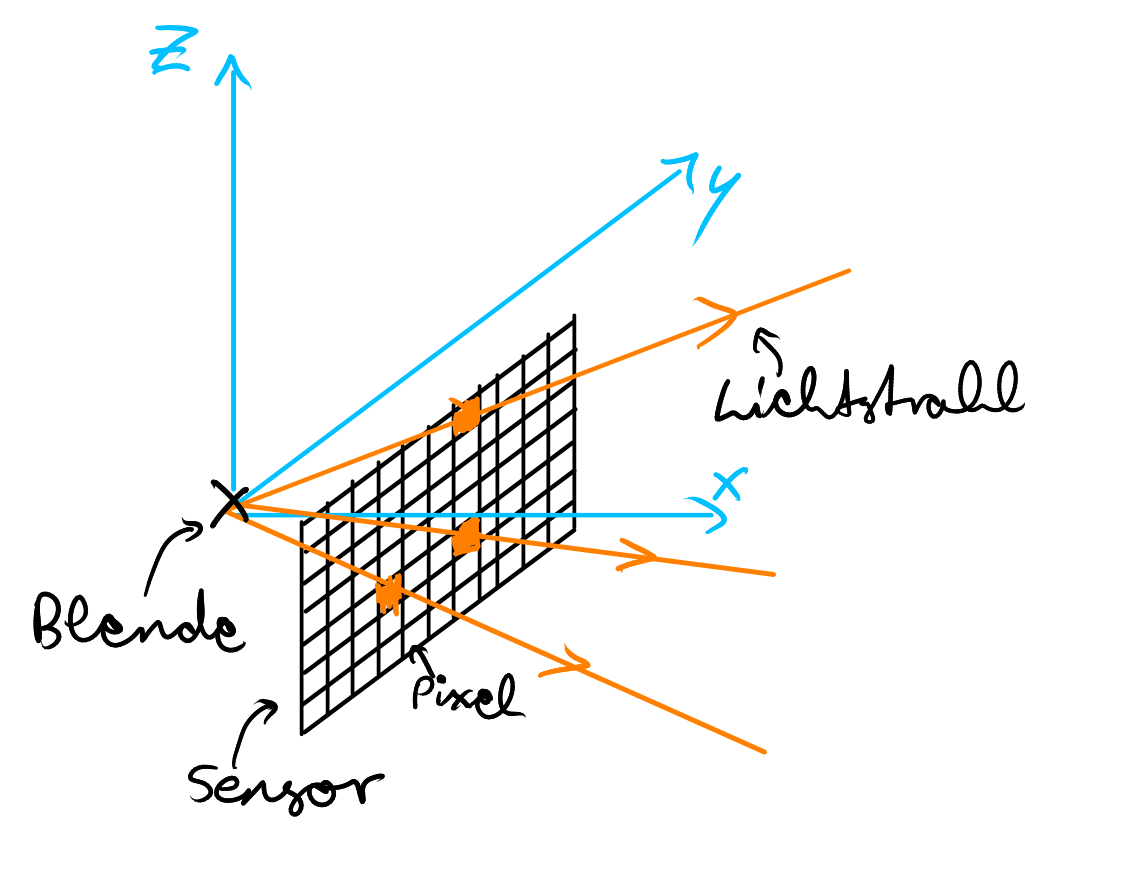

Damit können allerdings starke Treppenartefakte entstehen.
Um diese zu vermeiden werden die Lichtstrahlen nicht genau durch die Mitte jedes Pixels gesendet sondern durch einen zufälligen Punkt im Pixel.
<!--TODO erklärung Treppenartefakte-->

In [108]:
class ImageSize(NamedTuple):
    width: int
    height: int

class Camera:
    def __init__(self, imageSize: ImageSize) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        # setup
        self.imageSize = imageSize
        # sensor plane is 1 unit diagonal calculate the size of a pixel within 1 unit diagonal sensor
        self.unitPerPixel = np.sqrt(self.imageSize.width ** 2 + self.imageSize.height ** 2)
        self.sensorPosition = np.array([1,0,0])
        self.aperturePosition = np.array([0,0,0])
    
    def _getRay(self, pixelX:int,pixelY:int) -> Ray:
        assert 0 <= pixelX < self.imageSize.width, f"pixelX has to be in Image, was {pixelX}" 
        assert 0 <= pixelY < self.imageSize.height, f"pixelY has to be in Image, was {pixelY}"
        
        # set pixel position from 2d to 3d and add random offset within pixel (for anti aliasing)
        x = -self.imageSize.width/2 + pixelX + np.random.rand()
        y = -self.imageSize.height/2 + pixelY + np.random.rand()
        pixelPos = self.sensorPosition + np.array([0, x/self.unitPerPixel, y/self.unitPerPixel])
        
        # calculate ray direction
        rayDirection = normalizeVector(pixelPos - self.aperturePosition)
        
        # return Ray
        return Ray(self.aperturePosition, rayDirection, np.array([1,1,1]))

camera = Camera(ImageSize(8, 8))
camera._getRay(0,0)

Ray(location=array([0, 0, 0]), direction=array([ 0.92056404, -0.30231215, -0.24732411]), color=array([1, 1, 1]))


## Schnittpunkt eines Lichtstrahls mit einem Objekt

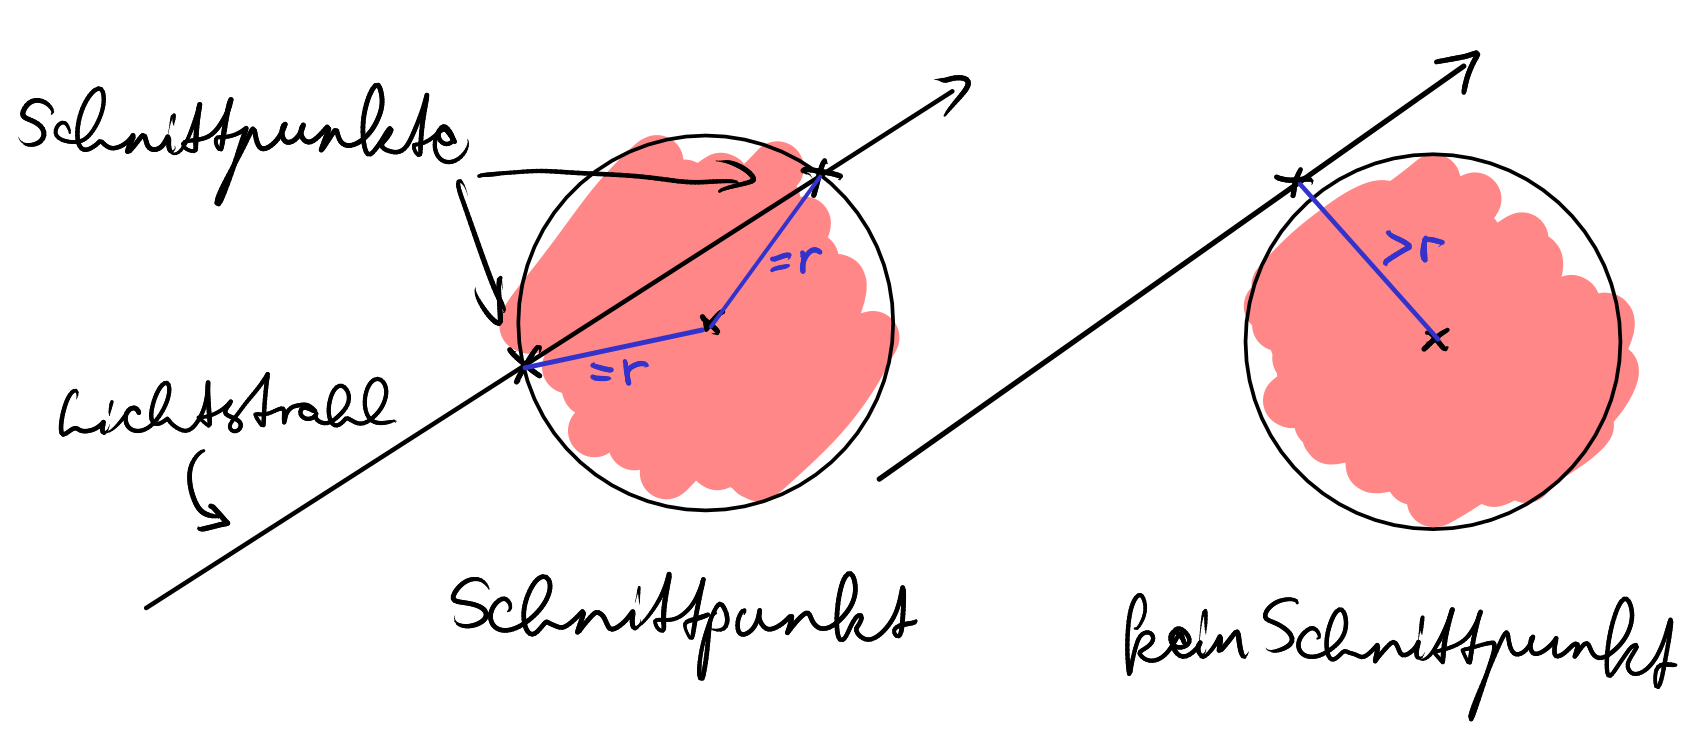

Nachdem der Lichtstrahl ausgesendet wurde, muss der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet werden.
Hier werden zur Vereinfachung nur Kreise als Objekte genutzt. 
Schnittpunkte sind dabei alle Punkte, die genau den Radius $r$ des Kreises von dessen Mittelpunkt $C$ entfernt sind.
also:

$$
|\vec{P}-\vec{C}|=r
$$

Für die Lichtstrahlen gilt damit

$$
|\vec{ray(t)}-\vec{C}|=r
\\
|\vec{O}+\vec{d}*t-\vec{C}| = r
$$

umgeformt ergibt das eine Quadratische Gleichung:

$$
|\vec{d}|^2*t^2+2t*<\vec{d},\vec{O}-\vec{C}>+<\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2=0
$$

um die Schnittpunkte heruaszufinden, muss die Gleichung nacht $t$ aufgelöst werden. 
Damit ergibt sich für $t$:

$$
a = |\vec{d}|^2
\\
b = 2*<\vec{d},\vec{O}-\vec{C}>
\\
c = <\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2
\\
t_{1,2}=\frac{-b\pm \sqrt{b^2-4*a*c}}{2*a}
$$

Damit gibt es nur Schnittpunkte für $b^2-4*a*c\geq 0$.  
In einer Szene kann es allerdings mehrere Objekte geben, die Schnittpunkte mit dem Lichtstrahl haben.
Der Auftreffpunkt des Lichtstrahls ist der erste Schnittpunkt der Geraden.
Das bedeutet der Auftreffpunkt ist der Punkt für den $t$ minimal aber größer $0$ ist.


In [109]:
from abc import ABC, abstractmethod 
from typing import Optional


class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[float]:
        pass

class Circle(Object):
    def __init__(self, center: Vec, radius: float) -> None:
        self.center = center
        self.radius = radius
        super().__init__()

    def hit(self, ray: Ray) -> Optional[float]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta >= 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t>0 else max(t1,t2)
            t = None if t<0 else t
            return t
        return None
    

ray = Ray(np.array([0,0,0]),np.array([1,0,0]), np.array([1,1,1]))
circle: Object = Circle(np.array([5,0,0]),1)
circle.hit(ray)

4.0

## Erster Test

Nun kann alles ein erstes Mal getestet werden.
Dafür wird eine einfache Render Funktion erstellt.
Diese kann unterscheiden, ob ein Objekt mit einem Lichtstrahl getroffen wurde oder nicht.
Der Ablauf hier ist wie folgt:

1. Es wird ein Lichtstrahl für ein Pixel generiert
2. Es wird berechnet ob der Lichtstrahl ein Objekt trifft
3. Wenn der Lichtstrahl ein Objekt trifft bekommt der Pixel den Wert 1, sonst 0

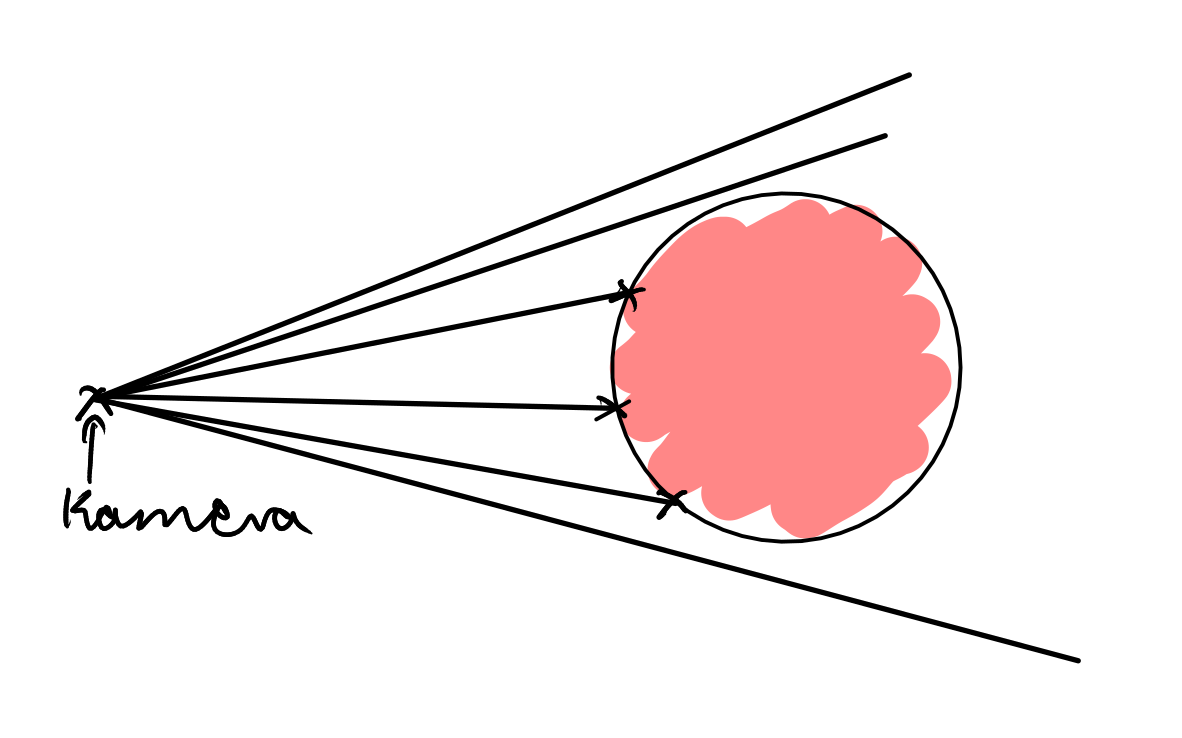

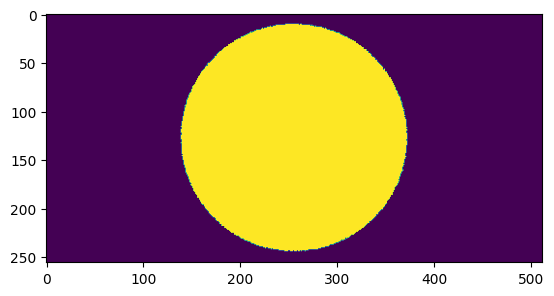

In [110]:
import matplotlib.pyplot as plt

camera = Camera(ImageSize(256, 512))
objects: list[Object] = [Circle(np.array([5, 0, 0]), 1)]

def render(camera: Camera, objects: list[Object]):
    img = np.zeros(camera.imageSize)
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) > 0:
                img[x, y] = 1
    return img
plt.imshow(render(camera, objects))

## Materialien

Bis jetzt gibt es nur zwei Zustände: Der Lichtstrahl trifft ein Objekt und der Lichtstrahl trifft kein Objekt.
Das reicht allerdings nicht aus, um ein Bild zu erzeugen. Dafür werden nun Materialien eingeführt, die den Objekten eine Farbe geben.   
Jedem Objekt wird nun ein Material zugeordnet.  
Später sollen die Materialien physikalische Eigenschaften das Materials, aus dem ein Objekt besteht, wiederspiegeln.  
Ein Material soll also in Zukunft aussagen welche Farbe ein Objekt hat, 
wie stark Licht reflektiert wird,
ob ein Objekt diffus ist oder spiegelt oder ob es durchsichtig ist.  
Um die Funktionalität der Materialien erst einmal zu testen, 
deffinieren die Materialen zuerst nur die Farbe des Objektes.

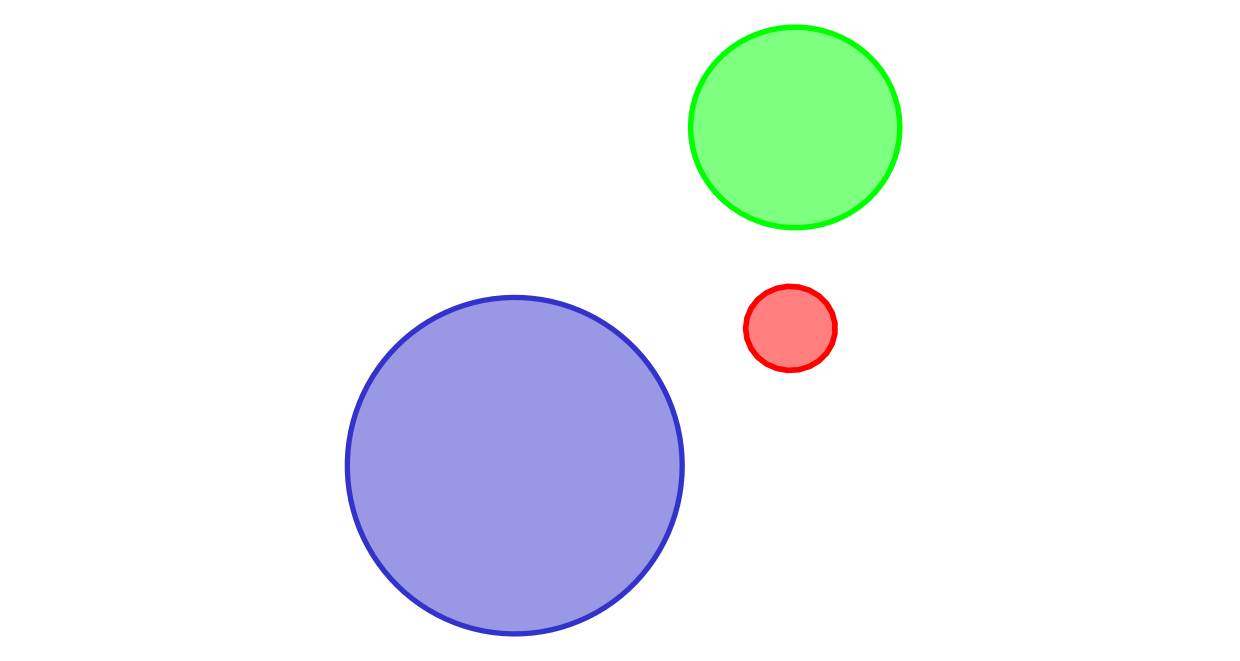


In [111]:
# NEU: es gibt ein Material, in dem eine Farbe deffiniert ist
class Material():
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

# NEU: wenn ein Objekt getroffen wird, muss zusätzlich das Material des Objekts zurück gegeben werden
class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[Tuple[float, Material]]:
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray) -> Optional[Tuple[float, Material]]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t > 0 else max(t1, t2)
            return None if t < 0 else (t, self.material)
        return None


Mit der Einführung von Materialien muss auch die Rendering Funktion angepasst werden. 
Ein Lichtstrahl nimmt nun die Farbe des Objekts an, das er getroffen hat
und jedes Pixel bekommt die Farbe seines zugehörigen Lichtstrahls.

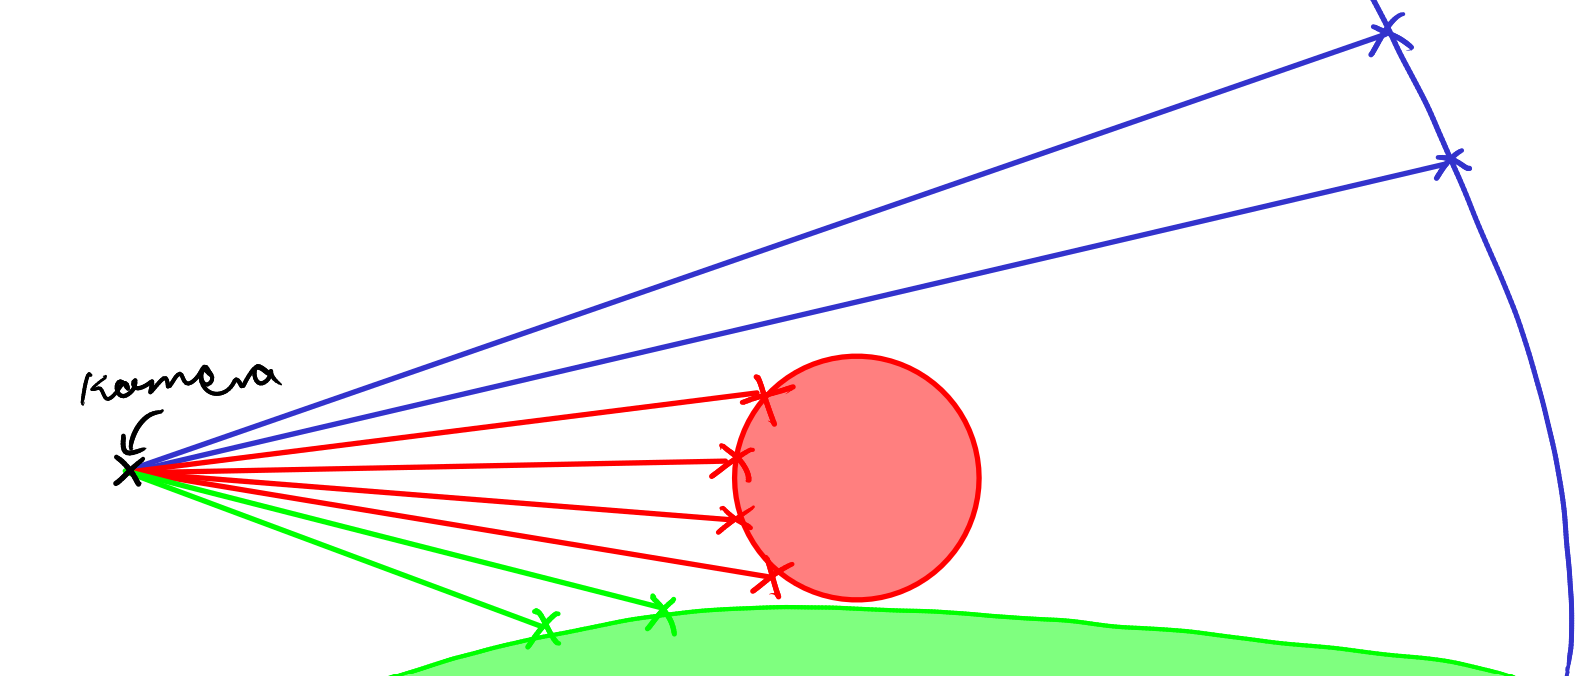

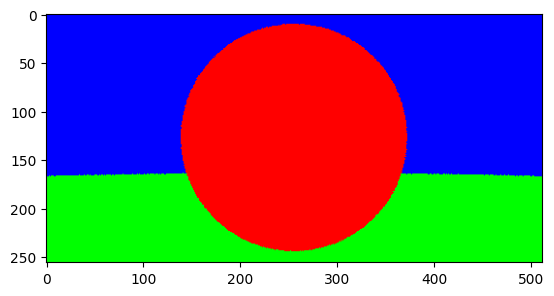

In [112]:
camera = Camera(ImageSize(256, 512))
objects: list[Object] = [Circle(np.array([50, 0, 0]), 10, Material([1,0,0])),
                         Circle(np.array([0, 5000, 0]), 4990, Material([0, 1, 0])),
                         Circle(np.array([0, 0, 0]), 5000, Material([0, 0, 1]))]

def render(camera: Camera, objects: list[Object]):
    img = np.zeros((camera.imageSize.width,camera.imageSize.height, 3))
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits: list[Tuple[float, Material]] = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) == 0:
                img[x, y] = [0,0,0]
                continue
            criticalHit = min(hits, key=lambda hit: hit[0])
            img[x,y] = criticalHit[1].color * ray.color
    return img
plt.imshow(render(camera, objects))


## Reflexion/Absorption

Während in dem vorherigen Modell die Lichtstrahlen mit dem Auftreffen auf ein Objekt beendet werden,
reflektieren Objekte in der realen Welt die Lichtstrahlen in aller Regel weiter.
Das soll in diesem Raytracing Modell auch dargestellt werden.

Die Reflektion, Absorption und Brechung des Lichts kann algorithmisch verschieden umgesetzt werden.
Eines haben die meisten dieser Algorithmen allerdings gemeinsam: 
Es muss bekannt sein in welcher Orientierung sich das Objekt befindet. Das wird mit dem Normalenvektor umgesetzt.
Also muss nun beim Auftreffen eines Lichtstrahls auf einem Objekt zusätzlich der Normalenvektor zurückgegeben werden.

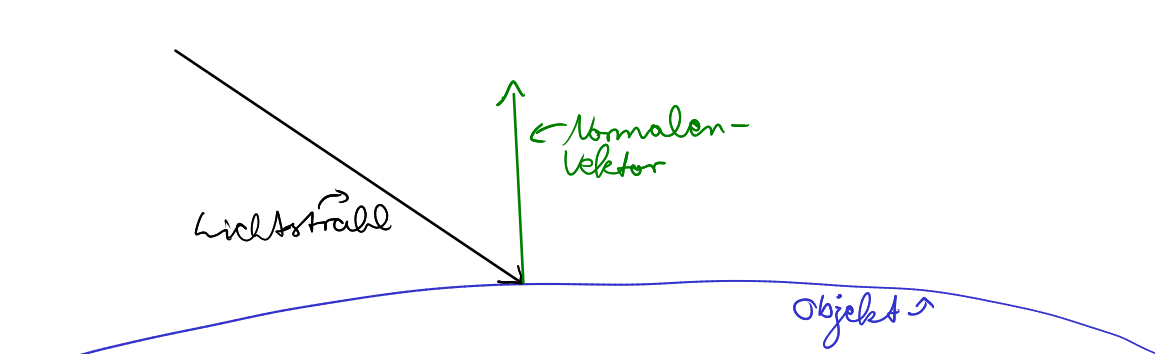

In [113]:
# NEU: neben dem Material, muss nun auch der Normalenvektor des Objekts 
# beim Auftreffen der Lichtstrahlen zurückgegeben werden.
# Um den Rückgabewert lesbarer zu machen, wird ein Rückgabeobjekt eingeführt

# NEU
class ObjHit(NamedTuple):
    t: float
    material: Material
    normal: Vec

class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[ObjHit]:
        # --------------------------- Neu ^
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray) -> Optional[ObjHit]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t > 0 else max(t1, t2)
            normal = normalizeVector(ray.at(t) - self.center)
            # Neu ^
            return None if t <= 0 else ObjHit(t, self.material, normal)
        return None

Ein einfaches Material-Modell, ist das Lambertsche Modell.
Mit diesem lassen sich diffuse Matterialien wie Papier oder Ton 
aber auch metallische und andere Spiegelnde Materialien darstellen.
Bei diffusen Materialien sagt das Lambertsche Reflektionsmodell aus, 
dass Licht in alle Richtungen gleich reflektiert wird,
aber bei hohem Auftreffwinkel mehr reflektiert wird als bei niedrigem Auftreffwinkel.
Die Intensität der Reflektion ist dabei proportional 
zum Cosinus zwischen Normalenverktor und Lichtstrahl.

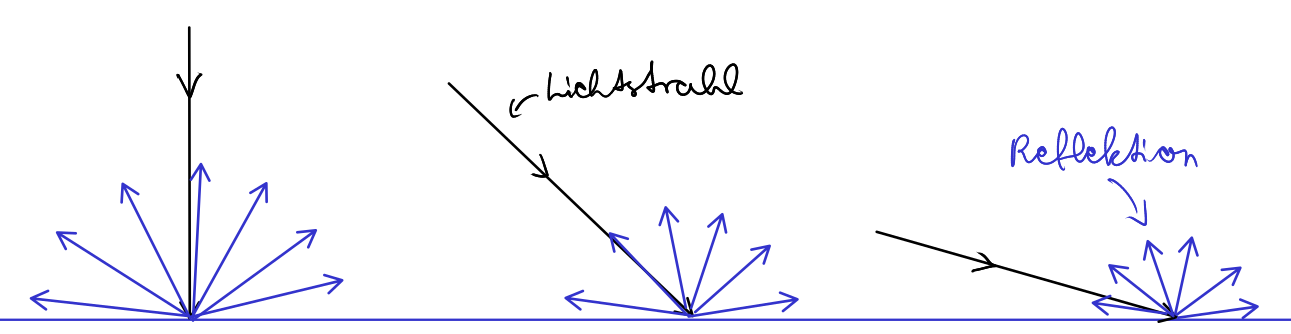

Grundsätzlich entstehen beim Reflektieren eines Lichtstrahls, wie in dieser Grafik dargestellt,
unendlich viele neue Lichtstrahlen, die in alle Richtungen reflektiert werden.
In einem Computer können in endlicher Zeit allerdings nicht unendlich viele Lichtstrahlen berechnet werden,
daher ist eine Aprroximation nötig.  
Anstatt bei der Reflektion unendlich viele Lichtstrahlen auszusenden wird nur ein Lichtstrahl entsprechend dem Lambertschen Reflektionsmodell ausgesendet.
Wenn dann die Anzahl der Lichtstrahlen, die die Kamera aussendet gegen unendlich geht
und damit auch die Anzahl der Lichtstrahlen die auf einen Punkt auftreffen gegen unendlich geht, 
wird das Modell genauer und damit das resultierende Bild besser.
Es muss außerdem beachtet werden, dass in diesem Raytracer die Lichtstrahlen von der Kamera ausgehen und beim Auftreffen auf eine Lichtquelle rückverfolgt werden. 
Daher muss das Reflektionsmodell quasi invertiert werden.

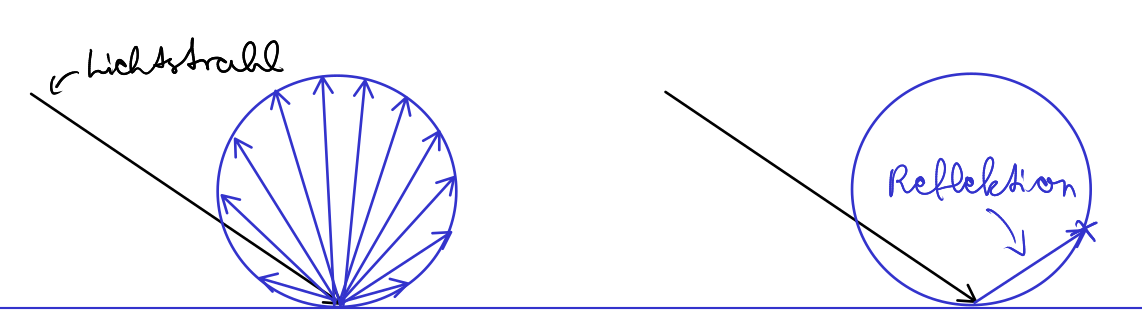

Links ist das Lambertsche Reflektionsmodell mit von der Kamera ausgehenden Lichtstrahlen dargestellt
und rechts ist die Approximation mit nur einem Lichtstrahl gezeigt.

Die Warscheinlichkeitsverteilung des Austrittswinkels ist $\text{pdf}(w_i)=\frac{\cos(\theta)}{\pi}$  
Damit lässt sich der Austrittswinkel abhängig von den Zufallsvariablen $\varepsilon_0$ und $\varepsilon_1$ berechnen.

$$
\theta = \cos^{-1}(\sqrt{\varepsilon_{0}}) \\
\phi = 2\pi \varepsilon_{1}
$$

Dieser Winkel kann dan wiefolgt in einen Vektor konvertiert werden:

$$
\vec{x}=
\begin{pmatrix}
\cos(\phi)*\sin(\theta)\\
\sin(\phi)*\sin(\theta)\\
\cos(\theta)\\
\end{pmatrix}
$$

umgekehrt funktioniert das wiefolgt:

$$
\phi = \tan^{-1}(\frac{y}{x})\\
\theta = \cos^{-1}(\frac{z}{\sqrt{x^2+y^2+z^2}})
$$

In [114]:
def cosHemisphere(epsilon) -> Vec:
    phi = np.arccos(np.sqrt(epsilon[0]))
    theta = 2 * np.pi * epsilon[1]
    return np.array([phi, theta])
def angleToVector(angle) -> Vec:
    phi = angle[0]
    theta = angle[1]
    return np.array([
        np.cos(phi)*np.sin(theta),
        np.sin(phi)*np.sin(theta),
        np.cos(theta)
    ])
def angleFromVector(vec: Vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    return np.array([
        np.arctan(y/x),
        np.arccos(z/np.sqrt(x**2+y**2+z**2)),
    ])

epsilon = np.random.rand(2)
angle = cosHemisphere(epsilon)
angleToVector(angle)

array([0.14711813, 0.2196668 , 0.96441835])

Neben einem Diffusen anteil, haben viele Materialien auch einen spiegelnden Anteil.
Dieser lässt sich mit dem Lambertschen Modell auch darstellen.

![lambert_specular.png](attachment:lambert_specular.png)

Dafür wird eine andere Warscheinlichkeitsverteilung verwendet: $\text{pdf}(w_i)=\frac{(\alpha+1)\cos^{\alpha}(\theta)}{2\pi}$  
Damit lässt sich der Austrittswinkel abhängig von den Zufallsvariablen $\epsilon_0$ und $\epsilon_1$ berechnen.

$$
\theta = \cos^{-1}(\varepsilon_{0}^{\frac{1}{\alpha+1}}) \\
\phi = 2\pi \varepsilon_{1}
$$

$\alpha$ ist dabei der Lambertsche Spiegelkoeffizien.

In [115]:
def powCosHemisphere(epsilon, alpha=1) -> Vec:
    phi = np.arccos(np.power(epsilon[0],1/(1+alpha)))
    theta = 2 * np.pi * epsilon[1]
    return np.array([phi, theta])

epsilon = np.random.rand(2)
angle = powCosHemisphere(epsilon,3)
print(angleToVector(angle))

# TODO move to material implementation (specular) and check.
normal = np.array([1,2,3])
incomming = np.array([2,3,4])
n = angleFromVector(normal)
i = angleFromVector(incomming)
out = 2*n-i+angle+np.pi
angleToVector(out)

[ 0.70344105  0.5347203  -0.46823595]


array([-0.15613127,  0.4862854 ,  0.85973806])

Mit diesem Wissen kann ein neues Material implementiert werden.
Da es mehrere verschiedene Materialien geben wird,
wird ein Material als abstrakte Klasse implementiert.
Diese hat eine Funktion, die mit dem eingehenden Lichtstrahl, dem Normalenvektor und dem Auftreffpunkt, den ausgehenden Lichtstrahl berechnet. 

Da die Szene allerdings vollkommen dunkel wäre, wenn es nur Diffuse Materialien gibt, muss es auch noch eine Lichtquelle geben. 
Dieses wird auch als Material, einem emissiven Material, implementiert.
Ein emmisives Material reflektiert keine Lichtstrahlen und muss beim Rendern das Rendering beenden.
Der Pfad eines Lichtstrahls in diesem Raytracer beginnt in der Kamera endet bei einer Lichtquelle.

In [116]:
# NEU: ein Material deffiniert eine Methode die mit dem eigehenden Lichtstrahl
# aus dem eingehenden Lichtstrahl berechnet
# Das Material ist außerdem abstrakt
class Material(ABC):
    @abstractmethod
    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        pass


# NEU: das Diffuse Material
class Diffuse(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        epsilon = np.random.rand(2)
        angle = powCosHemisphere(epsilon,3)
        angle += angleFromVector(normal)
        direction = angleToVector(angle)
        location = hitPoint
        color = inRay.color * self.color
        return Ray(location, direction, color)

# NEU: das Emmisive Material
class Emissive(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        direction = np.array([0,0,0])
        location = np.array([0,0,0])
        color = inRay.color * self.color
        return Ray(location, direction, color)


Nun muss auch die Render-Funktion angepasst werden.
Nachdem ein Lichtstrahl von der Kamera ausgesendet wurde, wird der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet. Zuvor hatte der Lichtstrahl hier geendet.
Nun wird der Lichtstrahl von dem Objekt bestimmt reflektiert wodurch ein neuer Lichtstrahl entsteht. 
Dieser kann dann auch wieder auf Objekte auftreffen und wieder reflektiert werden. Die Maximale Anzahl an Reflektionen ist durch die Variable `bounces` beschränkt.
Jeder Lichtstrahl ist einem Pixel zugeordnet und nachdem der Lichtstrahl nicht weiter reflektiert wird, (da entweder die maximale Anzahl Reflektionen erreicht ist, der Lichtstrahl in einer Lichtquelle angekommen ist oder der Lichtstrahl keine weiteren Objekte trifft) wird der Farbwert des Pixels um den Farbwert des Lichtstrahls erhöht.

In [117]:
camera = Camera(ImageSize(128, 128))
objects: list[Object] = [Circle(np.array([50, 0, 0]), 10, Diffuse([0.5, 0.7, 0.5])),
                         Circle(np.array([0, 5000, 0]),
                                4990, Diffuse([0.5, 0.5, 0.7])),
                         Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5]))]

def render(camera: Camera, objects: list[Object], bounces: int):
    img = np.zeros((camera.imageSize.width, camera.imageSize.height, 3))
    for j in range(5):
        for x in range(camera.imageSize.width):
            for y in range(camera.imageSize.height):
                ray = camera._getRay(x, y)
                for i in range(bounces):
                    hits = []
                    for obj in objects:
                        hit = obj.hit(ray)
                        if hit is not None:
                            hits.append(hit)
                    if len(hits) == 0:
                        img[x, y] = [0, 0, 0]
                        break
                    criticalHit = min(hits, key=lambda hit: hit[0])
                    point = ray.at(criticalHit.t)
                    ray = criticalHit.material.outRay(ray, criticalHit.normal, point)
                    if all(ray.direction==0):
                        break
                img[x, y] += ray.color
    return img

img = render(camera,objects, 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


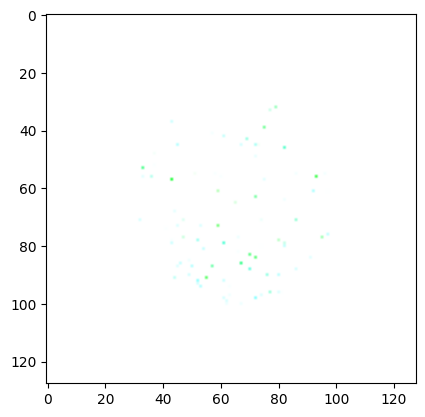

In [118]:
plt.imshow(img)

Das bild ist jetzt allerdings noch viel zu hell um sinnvoll angezeigt zu werden.
Hier verhält sich das Licht wie in der realen Welt, es ist unbegrenzt und linear.
Im Computer kann Licht aber nicht so dargestellt werden.
Zuerst müssen die Pixelwerte auf Werte zwischen 0 und 1 begrenzt werden. 
Dabei deffiniert der hellste Pixel im Bild den Maximalwert von 1.
Nun sind alle Werte auf Werte zwischen 0 und 1 begrenzt aber weriterhin linear.
Um das Bild richtig darzustellen ist noch eine Gamma Korrektur nötig.
Dafür wird die folgende Formel verwendet: $x_{\gamma}=x^{\gamma}$.
Die Gamma Korektur nutzt aus, dass das menschliche Auge 
auf Hellichkeitsänderungen in dunklen Bereichen stärker
als auf Hellichkeitsänderungen in hellen Bereichen reagiert.
Also benötigt ein Gamma codiertes Bild bei gleicher Hellichkeitsauflösung
eine geringere Bittiefe als ein linear codiertes Bild.
Die Gamma codierung sorgt so für eine Platzerspaarniss.
Computerbildschirme nutzen ein Gamma von $0.45$.
Um ein Lineares Bild auf einem solchen Bildschirm korrekt darzustellen,
muss das Bild auch mit einem Gamma von $0.45$ angezeigt werden. 
Alle Korrekturen werden von der `correctAndShowImage` funktion durchgeführt
und das Bild wird nun korrekt angezeigt.

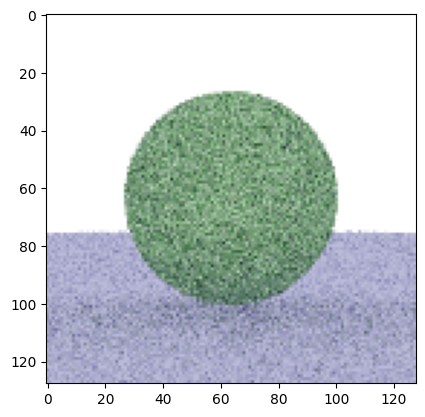

In [120]:
def correctAndShowImage(img):
    m = np.max(img)
    i = np.power((img/m),0.45)
    plt.imshow(i)
correctAndShowImage(img)

## Dreiecke

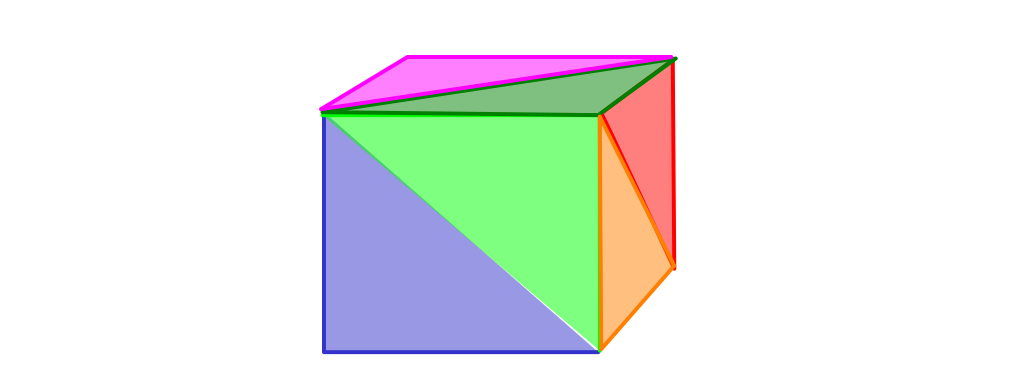

Bis jetzt kann der Raytracer nur Kugeln rendern. 
Reale Objekte bestehen allerdings nicht nur aus Kugel.
Dafür werden nun Dreiecke eingeführt.
Mit genügend vielen Dreiecken kann jedes Objekt erstellt werden.
Hier ist beispielsweise ein Quader mit Dreiecken dargestellt.
Zur besseren Erkennbarkeit sind die einzelnen Dreiecke verschieden eingefärbt.
Modelle werden meist mit sehr vielen Dreiecken dargestellt.
Daher ist es eigentlich unnötig Kugeln darstellen zu können.
Hier wurden Kugeln trotzdem als erstes Beispiel genommen, 
da sie algorithmisch einfacher umzusetzen sind.

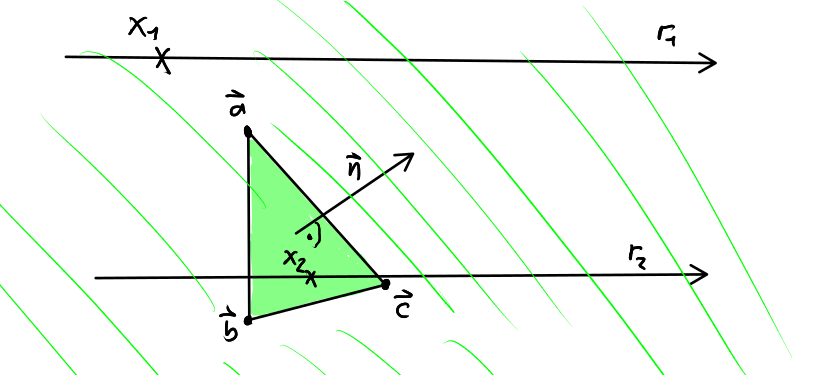

Ein Dreieck besteht aus 3 Punkten $\vec{a},\vec{b},\vec{c}$, die das Dreieck aufspannen.  
Um den Auftreffpunkt eines Lichtstrahls auf dem Dreieck zu berechnen, wird nun eine Ebene aus den drei Punkten gebildet.
Die Ebene soll in Normalenform vorliegen. 
Dafür wird der Normalenvektor gebildet: $\vec{n} = (\vec{b}-\vec{a}) \times (\vec{c}-\vec{a})$.
Ein Punkt liegt dann auf der Ebene, wenn für $\vec{x}$ gilt: $<(\vec{x}-\vec{a}),\vec{n}> = 0$.
Um den Punkt zu finden, bei dem ein Lichtstrahl auf der Ebene liegt,
muss ein $t$ gefunden werden, sodass $<((\vec{ray(t)})-\vec{a}),\vec{n}> = 0$

$$
<(\vec{O}+\vec{d}*t)-\vec{a},\vec{n}>=0
\\
<\vec{O},\vec{n}> + t*<\vec{d},\vec{n}> - <\vec{a},\vec{n}> =0
\\
t = - \frac{<\vec{O},\vec{n}>-<\vec{a},\vec{n}>}{<\vec{d},\vec{n}>}
\\
t = \frac{<\vec{a}-\vec{O},\vec{n}>}{<\vec{d},\vec{n}>}
$$

Wenn $<\vec{d},\vec{n}> = 0$ dann ist der Lichtstrahl Parallel und die Ebene ist nicht getroffen.
Auch wenn die Ebene getroffen wurde, heißt das nicht, dass der Punkt auch in dem Dreieck ist.
Das mus zusätzlich getestet werden. 
In der Grafik ist das auch erkenbar. Punkt $x_1$ ist zwar ein Schnittpunkt mit der Ebene, liegt aber nicht im Dreieck, Punkt $x_2$ dagegen schon.

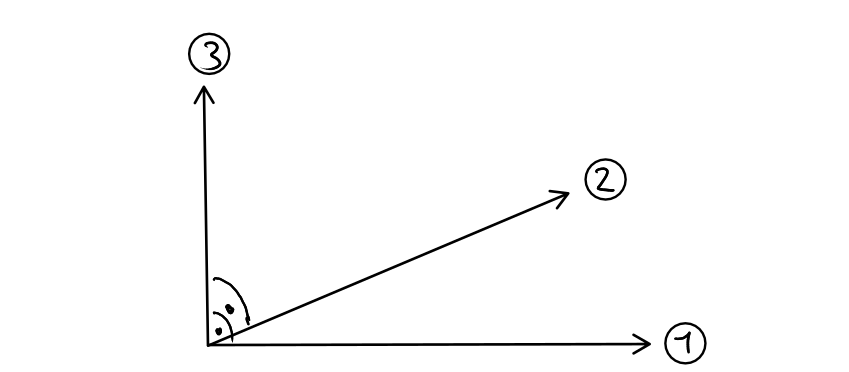

Um herauszufinden ob der Ebenenschnittpunkt im Dreieck liegt,
werden die Eigenschaften des Kreuzsproduktes ausgenutzt.
Wenn der zweite Vektor im Kreuzprodukt gegen den Uhrzeigersinn vom ersten Vektor liegt, 
dann ist das Kreuzprodukt ein Vektor zum Bebobachtungspunkt. 
Das ist in der Grafik oben dargestellt.
Wenn der zweite Vektor zum Ersten Vektor im Uhrzeigersinn steht, 
dann zeigt das Kreuzprodukt (Vektor 3) weg vom Beobachtungspunkt.

Bei dem Dreieck werden nun an allen Eckpunkten das Kreuzprodukt zwischen kante und Eckpunkt zu Ebenenschnittpunkt aufgestellt.
Wenn der Ebenenschnittpunkt im Dreieck liegt, zeigen alle Kreuzprodukte in Richtung des Normalenvektors.
Das Skalarprodukt von Kreuzprodukt und Normalenvektor muss also größer $0$ sein.    
Notation: $\vec{ab}$ ist der Vektor zwischen den Punkten $\vec{a}$ und $\vec{b}$ also $\vec{b} - \vec{a}$
Es gilt damit folgendes:

$$
<\vec{ab} \times \vec{ax},\vec{n}> \;> 0\\
<\vec{bc} \times \vec{bx},\vec{n}> \;> 0\\
<\vec{ca} \times \vec{cx},\vec{n}> \;> 0
$$

<!--https://www.youtube.com/watch?v=XgUhgSlQvic -->
<!--TODO hier muss erklärt werden wie das mit den Normalenvektoren funktioniert-->

In [34]:
class Triangle(Object):
    def __init__(self, abc: npt.NDArray[Vec], material: Material) -> None:
        self.a = abc[0]
        self.b = abc[1]
        self.c = abc[2]
        self.ab = self.b - self.a
        self.bc = self.c - self.b
        self.ca = self.a - self.c
        ac = self.c - self.a
        self.normal = normalizeVector(np.cross(self.ab,ac))
        self.material = material
        super().__init__()

    def hit(self, ray: Ray) -> Optional[ObjHit]:
        dn = np.dot(ray.direction,self.normal)
        if dn == 0:
            return None
        t = np.dot(self.a - ray.location,self.normal)/dn
        x = ray.at(t)
        abn = np.dot(np.cross(self.ab, x - self.a),self.normal) 
        bcn = np.dot(np.cross(self.bc, x - self.b),self.normal)
        can = np.dot(np.cross(self.ca, x - self.a),self.normal)
        if (abn > 0) and (bcn > 0) and (can > 0): 
            return ObjHit(t, self.material, self.normal)
        return None

In [35]:
triangle : Object = Triangle(np.array([[1,1,1],[0,0,0],[1,0,0]]), Emissive(np.array([1,2,3])))
ray = Ray(np.array([0.8,-0.5,-0.5]), np.array([0,1,0]), np.array([1,2,3]))

triangle.hit(ray)

Damit lässt sich nun zusätzlich zu den Kugeln zum Beispiel Würfel darstellen. Ein Würfel besteht einfach aus 12 Dreiecken.

<!--TODO Grafik Würfel-->

In [38]:
camera = Camera(ImageSize(128, 128))
# Circle(np.array([50, 0, 0]), 10, Diffuse([0.5, 0.7, 0.5])),
cubeMaterial = Diffuse([0.5, 0.7, 0.5])
cube = [
        # front
        Triangle(np.array([[50,5,-5],[50,5,5],[50,-5,-5]]), cubeMaterial),
        Triangle(np.array([[50,5,5],[50,-5,5],[50,-5,-5]]), cubeMaterial),
    
        # back
        Triangle(np.array([[60,5,-5],[60,5,5],[60,-5,-5]]), cubeMaterial),
        Triangle(np.array([[60,5,5],[60,-5,5],[60,-5,-5]]), cubeMaterial),
        
        # left
        Triangle(np.array([[50,5,-5],[50,-5,-5], [60,-5,-5]]), cubeMaterial),
        Triangle(np.array([[60,-5,-5],[60,5,-5], [50,5,-5]]), cubeMaterial),
    
        # right
        Triangle(np.array([[50,5,5],[50,-5,5], [60,-5,5]]), cubeMaterial),
        Triangle(np.array([[60,-5,5],[60,5,5], [50,5,5]]), cubeMaterial),
        
        # top
        Triangle(np.array([[50,-5,-5],[50,-5,5], [60,-5,-5]]), cubeMaterial),
        Triangle(np.array([[50,-5,5],[60,-5,5], [60,-5,-5]]), cubeMaterial),
    
        # bottom
        Triangle(np.array([[50,5,-5],[50,5,5], [60,5,-5]]), cubeMaterial),
        Triangle(np.array([[50,5,5],[60,5,5], [60,5,-5]]), cubeMaterial),
       ]

objects: list[Object] = [Circle(np.array([0, 5000, 0]), 4990, Diffuse([0.5, 0.5, 0.7])),
                         Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5])),
                         *cube
                        ]

img = render(camera,objects, 2)

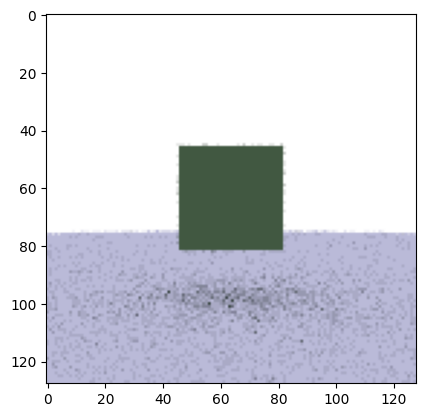

In [39]:
correctAndShowImage(img)